# CSC 365 Lab 8

Author: Andrew Cheung  
Email: acheun29@calpoly.edu

NOTE: The code requires a file named "account.info" with the username on the first line and password on the second line.

# Question 1
### In the regions for which we have data (Asia, Middle East and North Africa, Sub-Saharan Africa, and Latin America), how has the percent of urban unrest events with at least one death changed from 1960 to 2014?

I want to know if urban unrest events have beecome more likely or less likely to have a death, from 1960 to 2014. For simplicity, I used the StartDate as the year. These years include all the events in the database, except the three events with unknown years.
To obtain the results, I used a subquery to find the total number of events per year, and another subquery to find the number of events with a death per year. I joined their results on the year, and calculated the percent of events with a death for each year.
Then, I used matplotlib to make a scatterplot with a line of best fit.

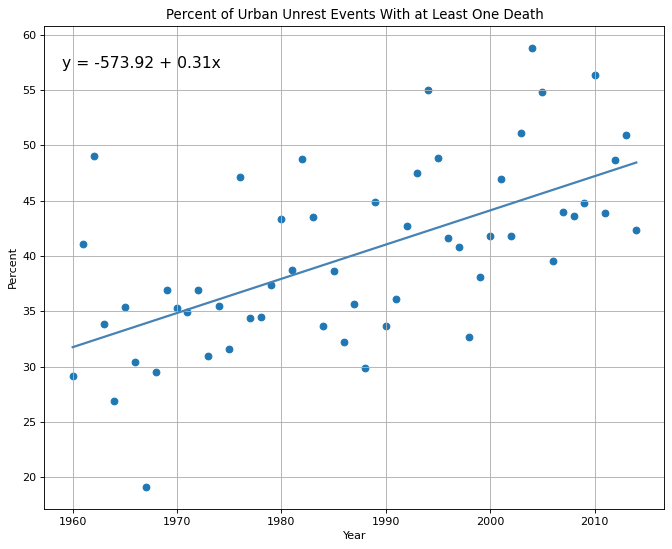



     Year  TotalEvents PercentWithDeath
0   1960           96          29.1667
1   1961           95          41.0526
2   1962           98          48.9796
3   1963           68          33.8235
4   1964           93          26.8817
5   1965           99          35.3535
6   1966          125          30.4000
7   1967          115          19.1304
8   1968          112          29.4643
9   1969          122          36.8852
10  1970          139          35.2518
11  1971          143          34.9650
12  1972          103          36.8932
13  1973           97          30.9278
14  1974          127          35.4331
15  1975          130          31.5385
16  1976          155          47.0968
17  1977          122          34.4262
18  1978          151          34.4371
19  1979          174          37.3563
20  1980          194          43.2990
21  1981          155          38.7097
22  1982          123          48.7805
23  1983          170          43.5294
24  1984          208 

In [7]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import numpy as np
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH total AS "
                        "(SELECT YEAR(e.StartDate) AS EventYear, COUNT(*) AS NumEvents "
                        "FROM Events AS e "
                        "WHERE YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                        "GROUP BY YEAR(e.StartDate)), "
                   "withdeath AS "
                        "(SELECT YEAR(e.StartDate) AS EventYear, COUNT(*) AS NumEvents "
                        "FROM Events AS e "
                        "WHERE YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                            # deathFlag = 1 means there was at least one death
                            "AND e.deathFlag = 1 "
                        "GROUP BY YEAR(e.StartDate)) "
                   "SELECT total.EventYear AS Year, "
                        "total.NumEvents AS TotalEvents, "
                        "withdeath.NumEvents / total.NumEvents * 100 AS PercentWithDeath "
                    "FROM total, withdeath "
                    "WHERE total.EventYear = withdeath.EventYear "
                    "ORDER BY total.EventYear;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Year", "TotalEvents", "PercentWithDeath"])
    years = np.array(df["Year"])
    percents = np.array([float(x) for x in df["PercentWithDeath"]])

    # line of best fit
    a, b = np.polyfit(years, percents, 1)

    # scatterplot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(years, percents)
    plt.plot(years, a * years + b, color="steelblue", linewidth=2)
    # linear regression equation
    plt.text(1959, 57, 'y = ' + '{:.2f}'.format(b) +
             ' + {:.2f}'.format(a) + 'x',
             size=14)
    plt.title("Percent of Urban Unrest Events With at Least One Death")
    plt.xlabel("Year")
    plt.ylabel("Percent")
    plt.grid()
    plt.show()

    # print the table
    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

### Question 1 Conclusions

I'd expected that the percentage of events with a death would have decreased, but the scatterplot shows that the percentage increased by 0.31% per year on average. 

# Question 2

### For each region, how many "spontaneous" and "organized events" took place?

...

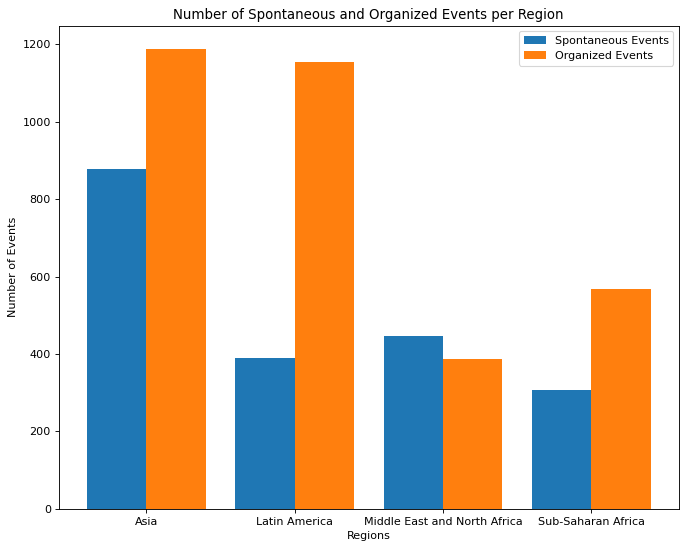



                          Region  SpontaneousEvents  OrganizedEvents
0                          Asia                879             1189
1                 Latin America                389             1155
2  Middle East and North Africa                446              386
3            Sub-Saharan Africa                307              569


In [8]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import numpy as np
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH sp AS "
                        "(SELECT Countries.Region, COUNT(*) AS Spontaneous "
                        "FROM EventActors AS ea, Events AS e, "
                            "ProblemTypes AS pt, Cities, Countries "
                        "WHERE ea.eventID = e.eventID "
                            "AND e.Ptype = pt.Ptype "
                            "AND e.City = Cities.CityId "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND INSTR(pt.ProblemType, 'Spontaneous') > 0 "
                        "GROUP BY Countries.Region), "
                    "org AS "
                        "(SELECT Countries.Region, COUNT(*) AS Organized "
                        "FROM EventActors AS ea, Events AS e, "
                            "ProblemTypes AS pt, Cities, Countries "
                        "WHERE ea.eventID = e.eventID "
                            "AND e.Ptype = pt.Ptype "
                            "AND e.City = Cities.CityId "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND INSTR(pt.ProblemType, 'Organized') > 0 "
                        "GROUP BY Countries.Region) "
                   "SELECT sp.Region, Spontaneous, Organized "
                   "FROM sp, org "
                   "WHERE sp.Region = org.Region "
                   "ORDER BY sp.Region;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Region", "SpontaneousEvents", "OrganizedEvents"])

    regions = df["Region"].tolist()
    sp = df["SpontaneousEvents"].tolist()
    org = df["OrganizedEvents"].tolist()

    x_axis = np.arange(len(regions))
    plt.figure(figsize=(10, 8), dpi=80)
    plt.bar(x_axis - 0.2, sp, 0.4, label="Spontaneous Events")
    plt.bar(x_axis + 0.2, org, 0.4, label="Organized Events")

    plt.xticks(x_axis, regions)
    plt.xlabel("Regions")
    plt.ylabel("Number of Events")
    plt.title("Number of Spontaneous and Organized Events per Region")
    plt.legend()
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

### Question 2 Conclusions

...

# Question 3

### Of the events which targeted the government, what is the distribution of types of problems in Sub-Saharan Africa?

...

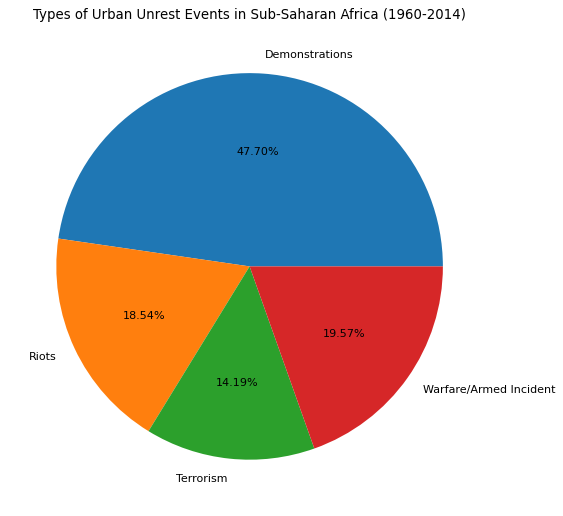



    Demonstrations  Riots  Terrorism  Warfare/Armed Incident
0             373    145        111                     153


In [9]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH dems AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                            "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                            "AND et.eventID = e.eventID "
                            "AND e.City = Cities.CityID "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND Countries.Region = 'Sub-Saharan Africa' "
                            "AND YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                            "AND INSTR(et.target, 'Government') > 0 "
                            "AND INSTR(pt.ProblemType, 'Demonstration') > 0), "
                   "riots AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                            "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                            "AND et.eventID = e.eventID "
                            "AND e.City = Cities.CityID "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND Countries.Region = 'Sub-Saharan Africa' "
                            "AND YEAR(e.StartDate) >= 1960 "
                            "AND YEAR(e.StartDate) <= 2014 "
                            "AND INSTR(et.target, 'Government') > 0 "
                            "AND INSTR(pt.ProblemType, 'Riot') > 0), "
                   "terr AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                           "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                           "AND et.eventID = e.eventID "
                           "AND e.City = Cities.CityID "
                           "AND Cities.Country = Countries.ISO3 "
                           "AND Countries.Region = 'Sub-Saharan Africa' "
                           "AND YEAR(e.StartDate) >= 1960 "
                           "AND YEAR(e.StartDate) <= 2014 "
                           "AND INSTR(et.target, 'Government') > 0 "
                           "AND INSTR(pt.ProblemType, 'Terrorism') > 0), "
                   "aw AS "
                       "(SELECT COUNT(*) AS Num "
                       "FROM Events AS e, ProblemTypes AS pt, "
                           "EventTargets AS et, Cities, Countries "
                       "WHERE e.Ptype = pt.Ptype "
                           "AND et.eventID = e.eventID "
                           "AND e.City = Cities.CityID "
                           "AND Cities.Country = Countries.ISO3 "
                           "AND Countries.Region = 'Sub-Saharan Africa' "
                           "AND YEAR(e.StartDate) >= 1960 "
                           "AND YEAR(e.StartDate) <= 2014 "
                           "AND INSTR(et.target, 'Government') > 0 "
                           "AND (INSTR(pt.ProblemType, 'Armed') > 0 "
                                "OR INSTR(pt.ProblemType, 'Warfare') > 0))"
                   "SELECT dems.Num AS Demonstrations, riots.Num AS Riots, "
                        "terr.Num AS Terrorism, "
                        "aw.Num AS `Warfare/Armed Incident` "
                   "FROM dems, riots, terr, aw;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Demonstrations", "Riots", "Terrorism", "Warfare/Armed Incident"])
    nums = [float(x) for x in df.iloc[0].tolist()]
    categories = df.columns

    # pie chart
    plt.figure(figsize=(10, 8), dpi=80, facecolor="white")
    plt.pie(nums, labels=categories, autopct='%.2f%%')
    plt.title("Types of Urban Unrest Events in Sub-Saharan Africa (1960-2014)")
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

### Question 3 Conclusions

...

# Question 4

### ...

...

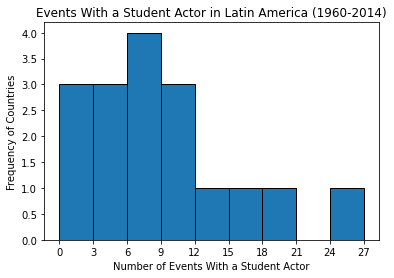



                Country  NumEvents
0                Chile         25
1              Bolivia         20
2             Colombia         17
3            Venezuela         12
4              Ecuador         10
5                 Peru         10
6            Argentina          9
7            Guatemala          8
8               Brazil          8
9   Dominican Republic          8
10              Mexico          6
11         El Salvador          4
12            Paraguay          4
13             Uruguay          3
14            Honduras          2
15              Panama          2
16               Haiti          1


In [11]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("WITH with_students AS "
                       "(SELECT Countries.Country, COUNT(DISTINCT e.eventID) AS Num "
                       "FROM Events AS e, EventActors AS ea, EventTargets AS et, Cities, Countries "
                       "WHERE e.City = Cities.CityID "
                            "AND ea.eventID = e.eventID "
                            "AND et.eventID = e.eventID "
                            "AND Cities.Country = Countries.ISO3 "
                            "AND Countries.Region = 'Latin America' "
                            "AND INSTR(ea.actor, 'Students') > 0 "
                            # "AND YEAR(e.StartDate) < 2000 "
                            "AND YEAR(e.StartDate) >= 1964 "
                            "AND YEAR(e.StartDate) <= 2014 "
                       "GROUP BY Countries.Country) "
                    "SELECT Country, IFNULL(Num, 0) AS EventsWithStudentActor "
                    "FROM (SELECT Country FROM Countries WHERE Region = 'Latin America') AS latam"
                        "LEFT JOIN with_students USING(Country) "
                    "ORDER BY EventsWithStudentActor DESC;")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Country", "NumEvents"])

    bins = [0, 3, 6, 9, 12, 15, 18, 21, 24, 27]
    ax = plt.subplots()[1]
    ax.set_xticks(bins)

    plt.hist(df["NumEvents"].tolist(), bins=bins, ec="black")
    plt.title("Events With a Student Actor in Latin America (1960-2014)")
    plt.xlabel("Number of Events With a Student Actor")
    plt.ylabel("Frequency of Countries")
    plt.show()

    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

### Question 4 Conclusions

...

# Question 5

### ...

...

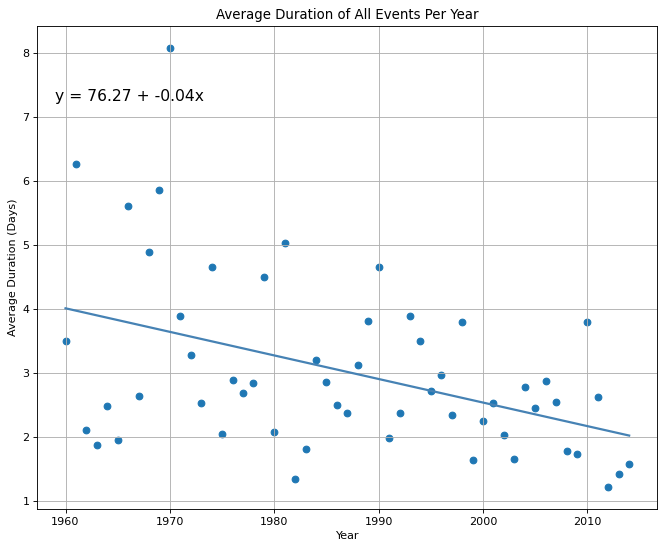



     Year AvgDuration
0   1960      3.5000
1   1961      6.2727
2   1962      2.1111
3   1963      1.8636
4   1964      2.4865
5   1965      1.9444
6   1966      5.6154
7   1967      2.6324
8   1968      4.8919
9   1969      5.8627
10  1970      8.0877
11  1971      3.8906
12  1972      3.2703
13  1973      2.5294
14  1974      4.6512
15  1975      2.0435
16  1976      2.8889
17  1977      2.6757
18  1978      2.8438
19  1979      4.4902
20  1980      2.0667
21  1981      5.0263
22  1982      1.3421
23  1983      1.8049
24  1984      3.2000
25  1985      2.8571
26  1986      2.5000
27  1987      2.3766
28  1988      3.1136
29  1989      3.8043
30  1990      4.6607
31  1991      1.9792
32  1992      2.3636
33  1993      3.8864
34  1994      3.5000
35  1995      2.7206
36  1996      2.9714
37  1997      2.3421
38  1998      3.7895
39  1999      1.6383
40  2000      2.2407
41  2001      2.5263
42  2002      2.0256
43  2003      1.6571
44  2004      2.7692
45  2005      2.4545
46  2006  

In [12]:
import matplotlib.pyplot as plt
import mysql.connector
from mysql.connector import Error
import numpy as np
import pandas as pd


def execute_sql(cursor):
    cursor.execute("USE LAB8;")

    cursor.execute("SELECT YEAR(e.StartDate) AS Year, "
                        "AVG(DATEDIFF(e.EndDate, e.StartDate) + 1) AS AvgDuration "
                   "FROM Events AS e, Cities, Countries "
                   "WHERE e.City = Cities.CityID "
                        "AND Cities.Country = Countries.ISO3 "
                        "AND Countries.Region = 'Asia' "
                        "AND YEAR(e.StartDate) >= 1960 "
                        "AND YEAR(e.EndDate) <= 2014 "
                   "GROUP BY YEAR(e.StartDate) "
                   "ORDER BY YEAR(e.StartDate);")

    records = cursor.fetchall()
    df = pd.DataFrame(records, columns=["Year", "AvgDuration"])
    years = np.array(df["Year"])
    durs = np.array([float(x) for x in df["AvgDuration"]])

    # line of best fit
    a, b = np.polyfit(years, durs, 1)

    # scatterplot
    plt.figure(figsize=(10, 8), dpi=80)
    plt.scatter(years, durs)
    plt.plot(years, a * years + b, color="steelblue", linewidth=2)
    # linear regression equation
    plt.text(1959, 7.25, 'y = ' + '{:.2f}'.format(b) +
             ' + {:.2f}'.format(a) + 'x',
             size=14)
    plt.title("Average Duration of All Events Per Year")
    plt.xlabel("Year")
    plt.ylabel("Average Duration (Days)")
    plt.grid()
    plt.show()

    # print the table
    print("\n\n", df)


def main():
    pwdFilename = "account.info"
    try:
        pwdFile = open(pwdFilename, "r")
        userName = pwdFile.readline().strip()
        dbName = userName
        passString = pwdFile.readline().strip()
    except FileNotFoundError as e:
        print(e)
        return 1

    hostName = "mysql.labthreesixfive.com"
    portName = "3306"

    connector = None
    cursor = None
    try:
        connector = mysql.connector.connect(host=hostName, port=portName,
                                            database=dbName, user=userName,
                                            password=passString)
        cursor = connector.cursor()
        execute_sql(cursor)

    except Error as e:
        print("connection error:", e)

    finally:
        if connector is not None and connector.is_connected():
            if cursor is not None:
                cursor.close()
            connector.close()


if __name__ == "__main__":
    main()

### Question 5 Conclusions

...